# Loyalty Clustering


In [1]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [7]:
loyalty_clustering = pd.read_csv("df_ready_for_clustering.csv")
loyalty_clustering.head()


,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,TotalFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,225,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,245,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,211,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,108,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,181,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [8]:
features = ['LoyaltyIndex','Time on Program', 'HasBonus', 'EnrollmentMonth']
loyalty_clustering = loyalty_clustering[features]
loyalty_clustering.head()

,LoyaltyIndex,Time on Program,HasBonus,EnrollmentMonth
0,709.589704,874,0,8
1,418.130598,2122,0,3
2,616.640254,884,0,7
3,1014.088728,1242,0,8
4,714.181936,1816,0,1


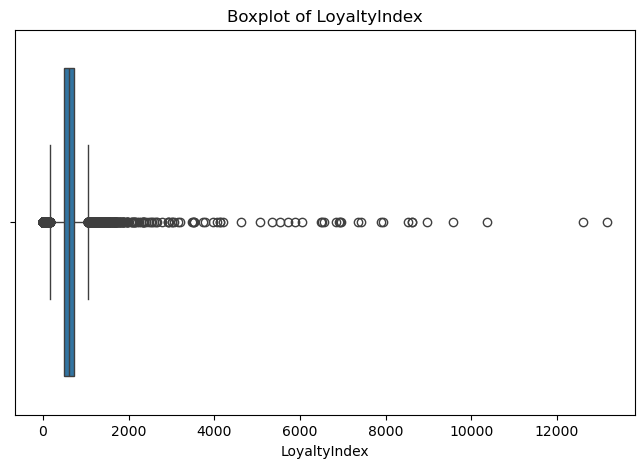

In [9]:
# check for outliers in 'LoyaltyIndex' using boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=loyalty_clustering['LoyaltyIndex'])
plt.title('Boxplot of LoyaltyIndex')
plt.show()

We will not do anything to the outliers, since when using DBSCAN we have 95% of noise, so we will just standardized.

In [10]:
# Cell 7: Remove outliers using DBSCAN
#from collections import Counter
#dbscan = DBSCAN(eps=2.0, min_samples=20, n_jobs=4)
#dbscan_labels = dbscan.fit_predict(loyalty_clustering)

# Check outlier count
#outlier_count = Counter(dbscan_labels)
#print(f"DBSCAN results: {outlier_count}")
#print(f"Outliers detected: {outlier_count[-1]}")
#print(f"Core customers: {outlier_count[0]}")

# Save outliers for later classification
#df_out = loyalty_clustering[dbscan_labels == -1].copy()

# Filter to core customers only
#df = loyalty_clustering[dbscan_labels != -1].copy()
#print(f"\nWorking with {len(df):,} core customers")
#print(f"Outliers saved for later: {len(df_out)}")

In [11]:
# Normalize numerical columns
numerical_columns = loyalty_clustering.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = MinMaxScaler()
loyalty_clustering[numerical_columns] = scaler.fit_transform(loyalty_clustering[numerical_columns])
loyalty_clustering.head()

,LoyaltyIndex,Time on Program,HasBonus,EnrollmentMonth
0,0.053931,0.354564,0.0,0.636364
1,0.031779,0.860852,0.0,0.181818
2,0.046867,0.358621,0.0,0.545455
3,0.077074,0.503854,0.0,0.636364
4,0.054280,0.736714,0.0,0.000000


## Hierarchical Clustering

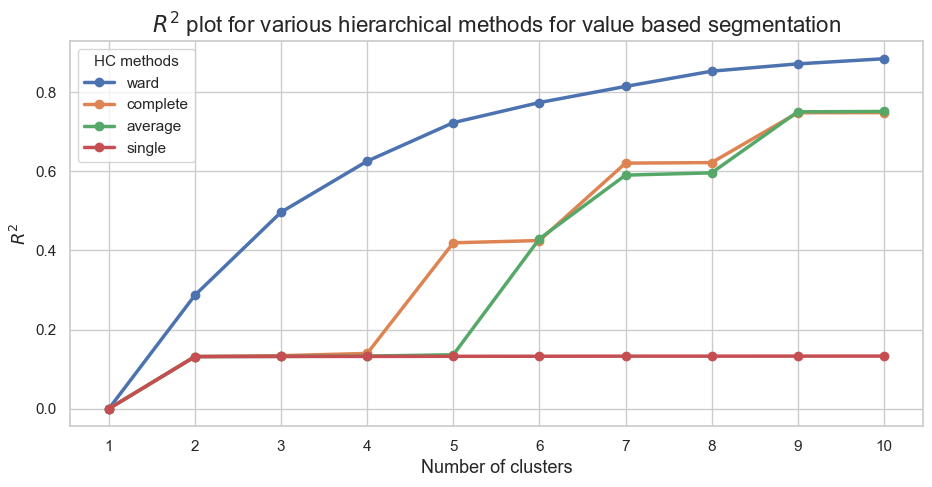

In [12]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = loyalty_clustering.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=loyalty_clustering[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()



In [13]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(loyalty_clustering, method="ward") 

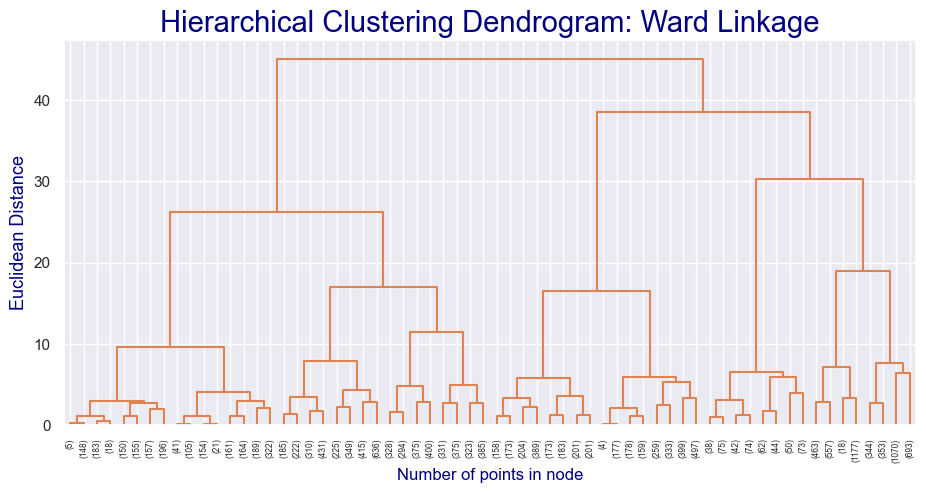

In [14]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

Lets try 4,5 and 6 clusters

In [15]:
# Test with nclusters=4
hc = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',
    linkage='ward'
)
hc_labels4 = hc.fit_predict(loyalty_clustering)


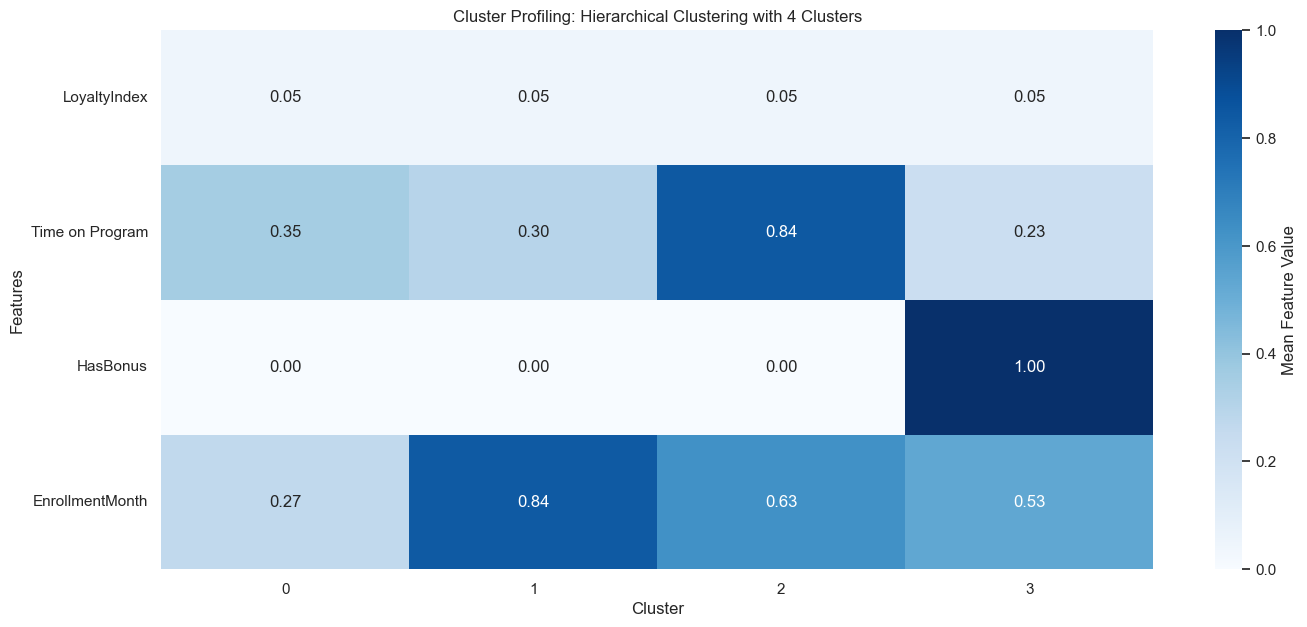

In [16]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels4

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 4 Clusters")
plt.yticks(rotation=0)
plt.show()


In [17]:
# Now do the same but for nclusters=4
hc = AgglomerativeClustering(
    n_clusters=5,
    metric='euclidean',
    linkage='ward'
)
hc_labels5 = hc.fit_predict(loyalty_clustering)


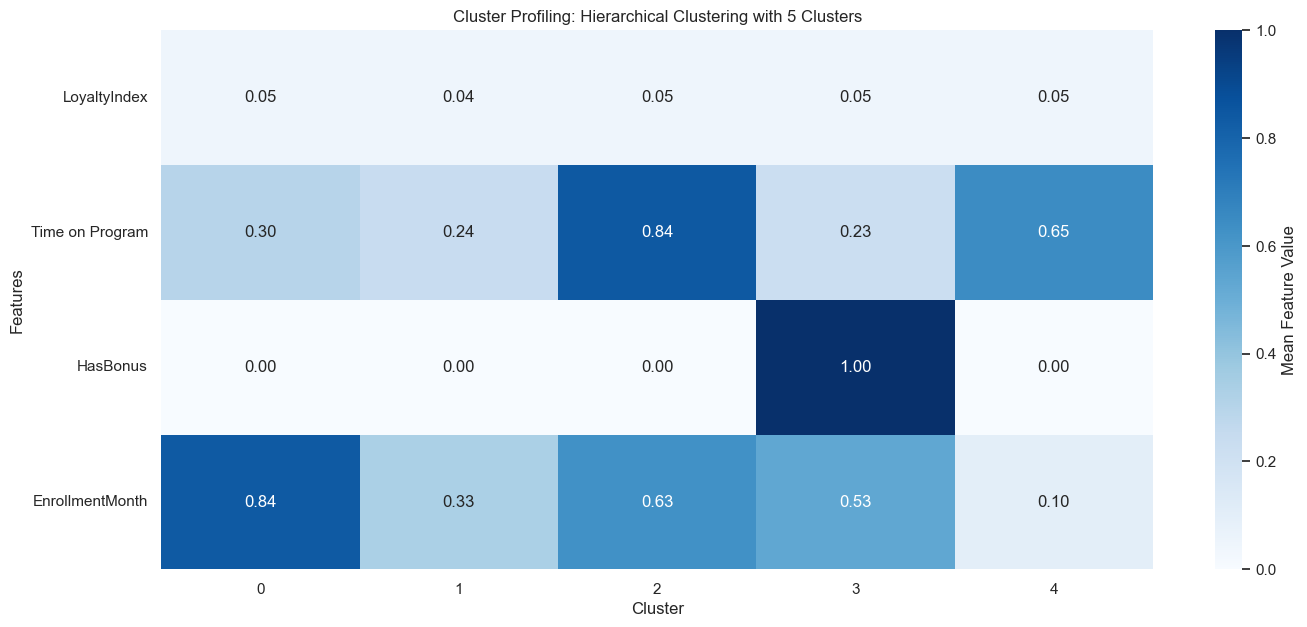

In [18]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels5

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 5 Clusters")
plt.yticks(rotation=0)
plt.show()


In [20]:
# Now nclusters=5
hc = AgglomerativeClustering(
    n_clusters=6,
    metric='euclidean',
    linkage='ward'
)
hc_labels6 = hc.fit_predict(loyalty_clustering)


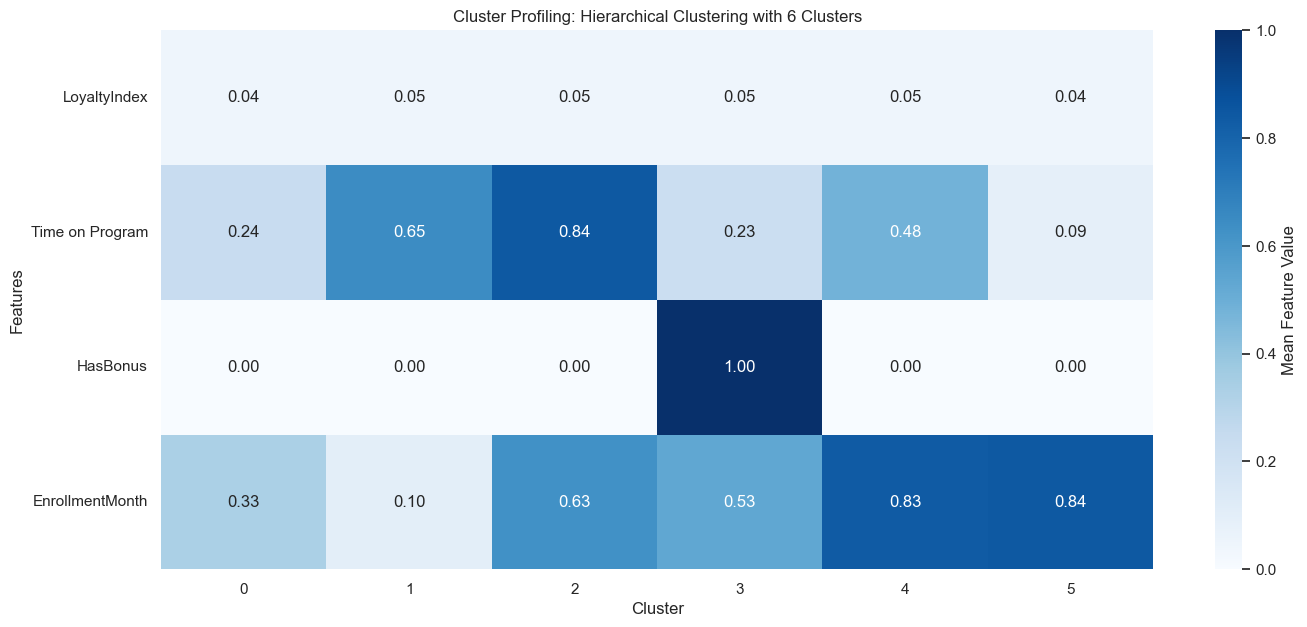

In [21]:
X = loyalty_clustering.copy()
X['labels'] = hc_labels6

cluster_means = X.groupby('labels')[loyalty_clustering.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 6 Clusters")
plt.yticks(rotation=0)
plt.show()


## KMEANS

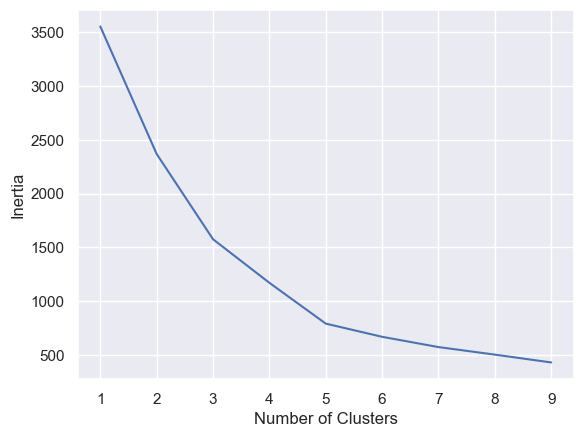

In [22]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(loyalty_clustering)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()


cluster,0,1,2,3,4
LoyaltyIndex,0.044012,0.047494,0.047186,0.044132,0.048631
Time on Program,0.167364,0.698054,0.755283,0.221243,0.225012
HasBonus,0.000000,0.000000,0.000000,0.000000,1.000000
EnrollmentMonth,0.776045,0.784050,0.264743,0.231274,0.534934


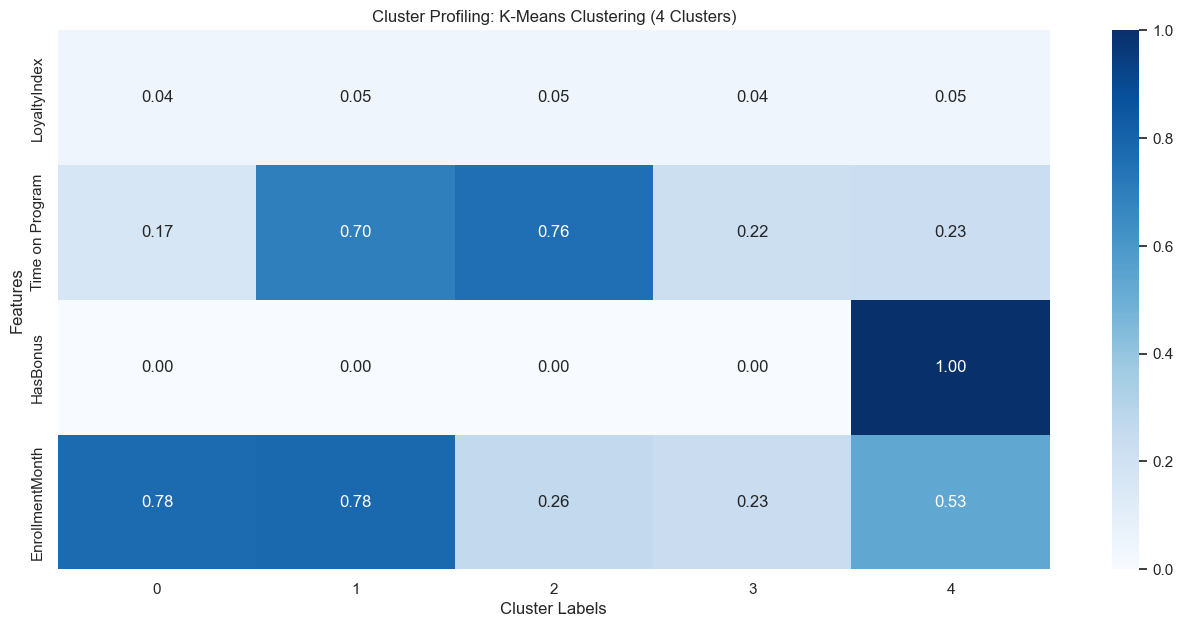

In [ ]:
km = KMeans(n_clusters=5, init="k-means++", random_state=94)
km_labels_5 = km.fit_predict(loyalty_clustering)

df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = km_labels_5

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (5 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

cluster,0,1,2,3,4,5
LoyaltyIndex,0.043857,0.047413,0.047011,0.047599,0.048631,0.043055
Time on Program,0.157815,0.701919,0.825916,0.468966,0.225012,0.158016
HasBonus,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
EnrollmentMonth,0.787201,0.805356,0.293925,0.277355,0.534934,0.230111


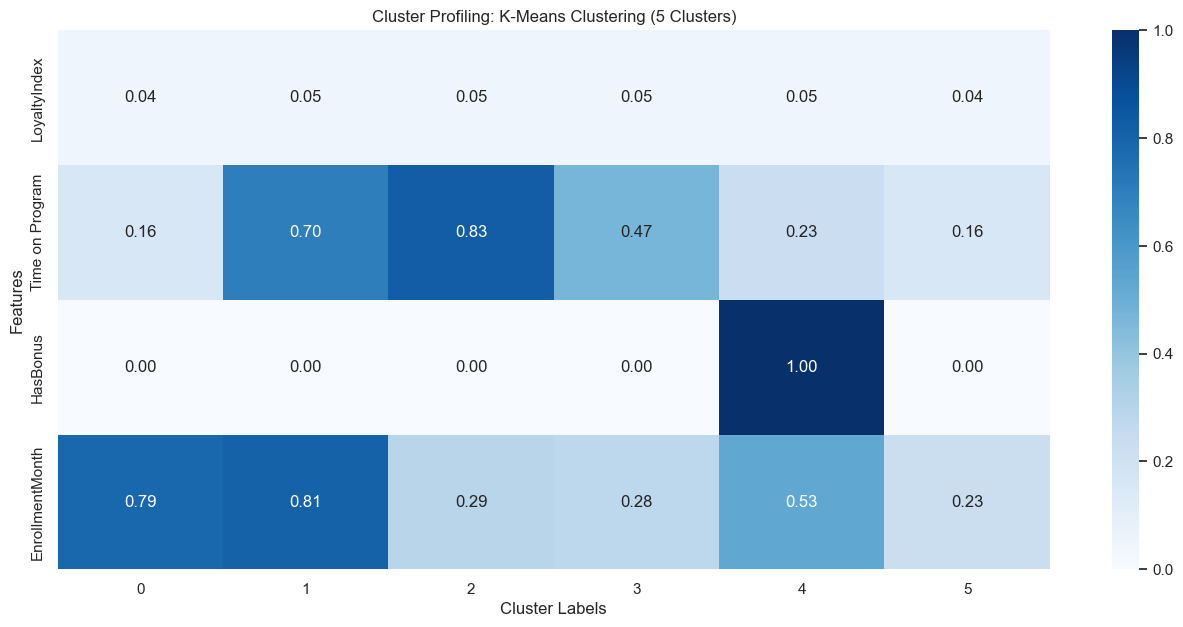

In [ ]:
km = KMeans(n_clusters=6, init="k-means++", random_state=94)
km_labels_6 = km.fit_predict(loyalty_clustering)

df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = km_labels_6
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (6 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

In [26]:
# Now let's compare all results for all different methods and nclusters
X = loyalty_clustering.copy()
X['hc_3'] = hc_labels6
X['hc_4'] = hc_labels4
X['hc_5'] = hc_labels5
X['km_4'] = km_labels_6
X['km_5'] = km_labels_5
# Features used for clustering
X = loyalty_clustering.copy()
# Compute metrics for KMeans with 2 clusters
kmeans_6_silhouette = silhouette_score(X, km_labels_6)
kmeans_6_calinski_harabasz = calinski_harabasz_score(X, km_labels_6)
kmeans_6_davies_bouldin = davies_bouldin_score(X, km_labels_6)
# Compute metrics for KMeans with 3 clusters
kmeans_5_silhouette = silhouette_score(X, km_labels_5)
kmeans_5_calinski_harabasz = calinski_harabasz_score(X, km_labels_5)
kmeans_5_davies_bouldin = davies_bouldin_score(X, km_labels_5)

comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (4 Clusters)", "Hierarchical (6 Clusters)", "Hierarchical (5 Clusters)", "K-Means (6 Clusters)", "K-Means (5 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels4), silhouette_score(X, hc_labels6), silhouette_score(X, hc_labels5), kmeans_6_silhouette, kmeans_5_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels4), calinski_harabasz_score(X, hc_labels6), calinski_harabasz_score(X, hc_labels5), kmeans_6_calinski_harabasz, kmeans_5_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels4), davies_bouldin_score(X, hc_labels6), davies_bouldin_score(X, hc_labels5), kmeans_6_davies_bouldin, kmeans_5_davies_bouldin]
})
comparison_table.head(6)

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (4 Clusters),0.359977,9216.505160,0.818220
1,Hierarchical (6 Clusters),0.339288,11301.505734,0.812072
2,Hierarchical (5 Clusters),0.352604,10782.397834,0.799871
3,K-Means (6 Clusters),0.398544,13532.136823,0.861192
4,K-Means (5 Clusters),0.428905,14364.914620,0.727084


### Conclusion 
    
    Hierarchical Clustering (4 Clusters) is the optimal solution, offering clearer customer segmentation with better operational simplicity. The four segments provide distinct, actionable profiles based on customer lifecycle and tenure patterns, making it easier to design targeted marketing strategies without the complexity of managing additional clusters. This approach delivers the best balance between statistical rigor and business practicality for customer segmentation analysis.


Let's try GMM and DBSCAN, since we have a lot of outliers in Loyalty Index, and this methods deal better with this.


## GMM

cluster,0,1,2,3
LoyaltyIndex,0.077075,0.031542,0.047719,0.043127
Time on Program,0.216212,0.329725,0.566781,0.077166
HasBonus,0.930894,0.000000,0.000000,0.000000
EnrollmentMonth,0.544531,0.558593,0.516376,0.474024


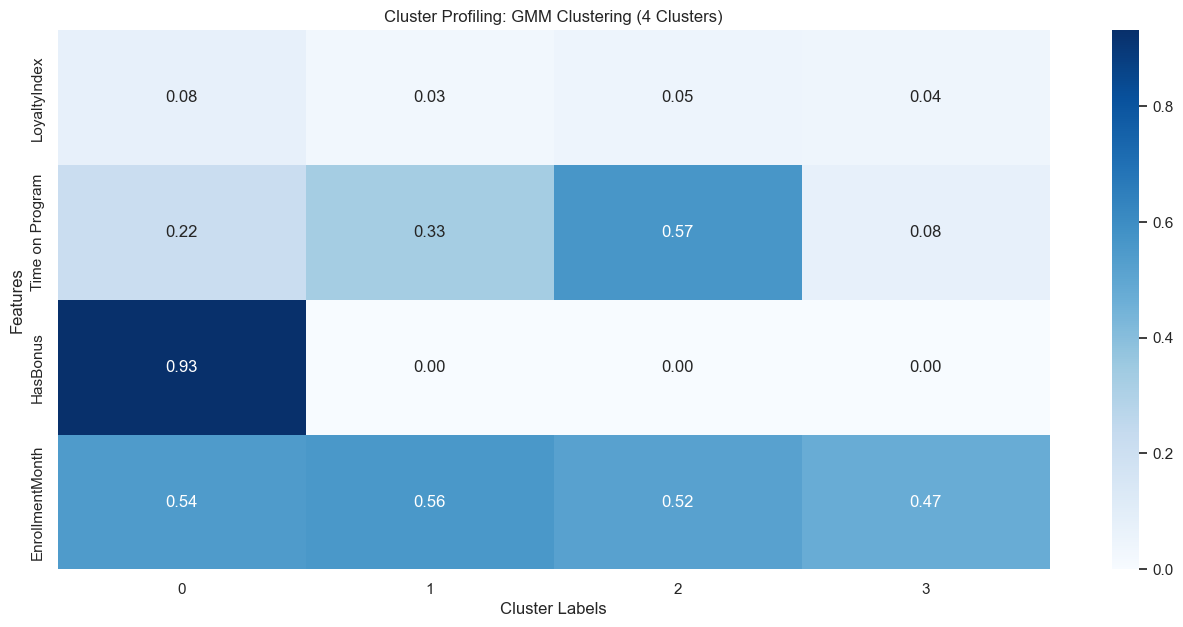

In [27]:
# Now let's try GMM
# We know that hierarchical with 4 clusters worked well
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=94)
gmm_labels_4 = gmm.fit_predict(loyalty_clustering)
df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = gmm_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()
display(cluster_profile_orig.T)
plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: GMM Clustering (4 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()



cluster,0,1,2,3,4
LoyaltyIndex,0.089858,0.045790,0.048828,0.038089,0.048631
Time on Program,0.026937,0.626108,0.594489,0.118501,0.225012
HasBonus,0.000000,0.000000,0.000000,0.000000,1.000000
EnrollmentMonth,0.881888,0.788415,0.260305,0.492322,0.534934


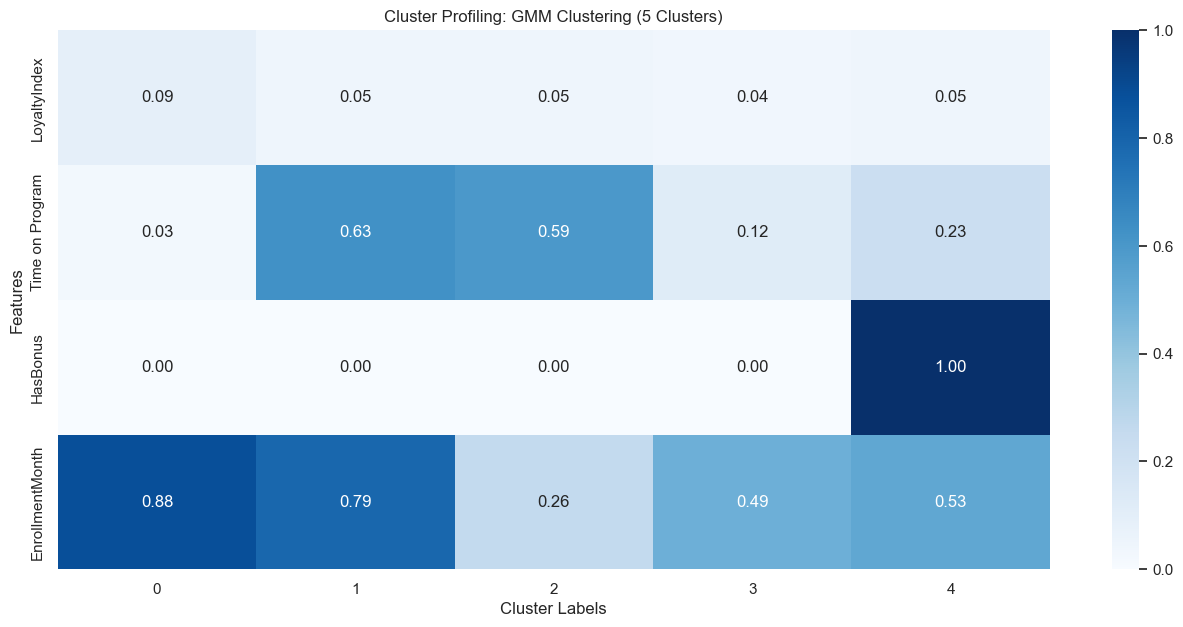

In [28]:
# Now let's try GMM
# We know that K means with 4 clusters worked well
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=94)
gmm_labels_5 = gmm.fit_predict(loyalty_clustering)
df_value_based_with_clusters = loyalty_clustering.copy()
df_value_based_with_clusters['cluster'] = gmm_labels_5
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()
display(cluster_profile_orig.T)
plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: GMM Clustering (5 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()



## DBSCAN

In [32]:
# Now try DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=4)
dbscan_labels = dbscan.fit_predict(loyalty_clustering)

In [33]:
# Compare the results between hierarchical 4 clusters and gmm
# results i am saying metrics
X = loyalty_clustering.copy()
X['hc_4'] = hc_labels4
X['gmm_4'] = gmm_labels_4
X['gmm_5'] = gmm_labels_5
X['dbscan'] = dbscan_labels
# silhouette score
hc_4_silhouette = silhouette_score(X, hc_labels4)
gmm_4_silhouette = silhouette_score(X, gmm_labels_4)
gmm_5_silhouette = silhouette_score(X, gmm_labels_5)
dbscan_silhouette = silhouette_score(X, dbscan_labels)
# calinski harabasz score
hc_4_calinski_harabasz = calinski_harabasz_score(X, hc_labels4)
gmm_4_calinski_harabasz = calinski_harabasz_score(X, gmm_labels_4)
gmm_5_calinski_harabasz = calinski_harabasz_score(X, gmm_labels_5)
dbscan_calinski_harabasz = calinski_harabasz_score(X, dbscan_labels)
# davies bouldin score
hc_4_davies_bouldin = davies_bouldin_score(X, hc_labels4)
gmm_4_davies_bouldin = davies_bouldin_score(X, gmm_labels_4)
gmm_5_davies_bouldin = davies_bouldin_score(X, gmm_labels_5)
dbscan_davies_bouldin = davies_bouldin_score(X, dbscan_labels)
comparison_table_gmm = pd.DataFrame({
    "Clustering Method": ["Hierarchical (4 Clusters)", "GMM (4 Clusters)", "GMM (5 Clusters)", "DBSCAN"],
    "Silhouette Score": [hc_4_silhouette, gmm_4_silhouette, gmm_5_silhouette, dbscan_silhouette],
    "Calinski-Harabasz Index": [hc_4_calinski_harabasz, gmm_4_calinski_harabasz, gmm_5_calinski_harabasz, dbscan_calinski_harabasz],
    "Davies-Bouldin Index": [hc_4_davies_bouldin, gmm_4_davies_bouldin, gmm_5_davies_bouldin, dbscan_davies_bouldin]
})
comparison_table_gmm.head(4)


,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (4 Clusters),0.389799,8102.030528,1.189042
1,GMM (4 Clusters),0.312573,3728.795747,1.430469
2,GMM (5 Clusters),0.394080,7343.453077,1.077937
3,DBSCAN,0.577153,1913.548804,0.405520


We will continue to use Hierarchical, since it is the easiest way of analysing clusters.

## Cluster Profilling

  Cluster 0: 7,753 customers
  Cluster 1: 4,675 customers
  Cluster 2: 3,688 customers
  Cluster 3: 458 customers


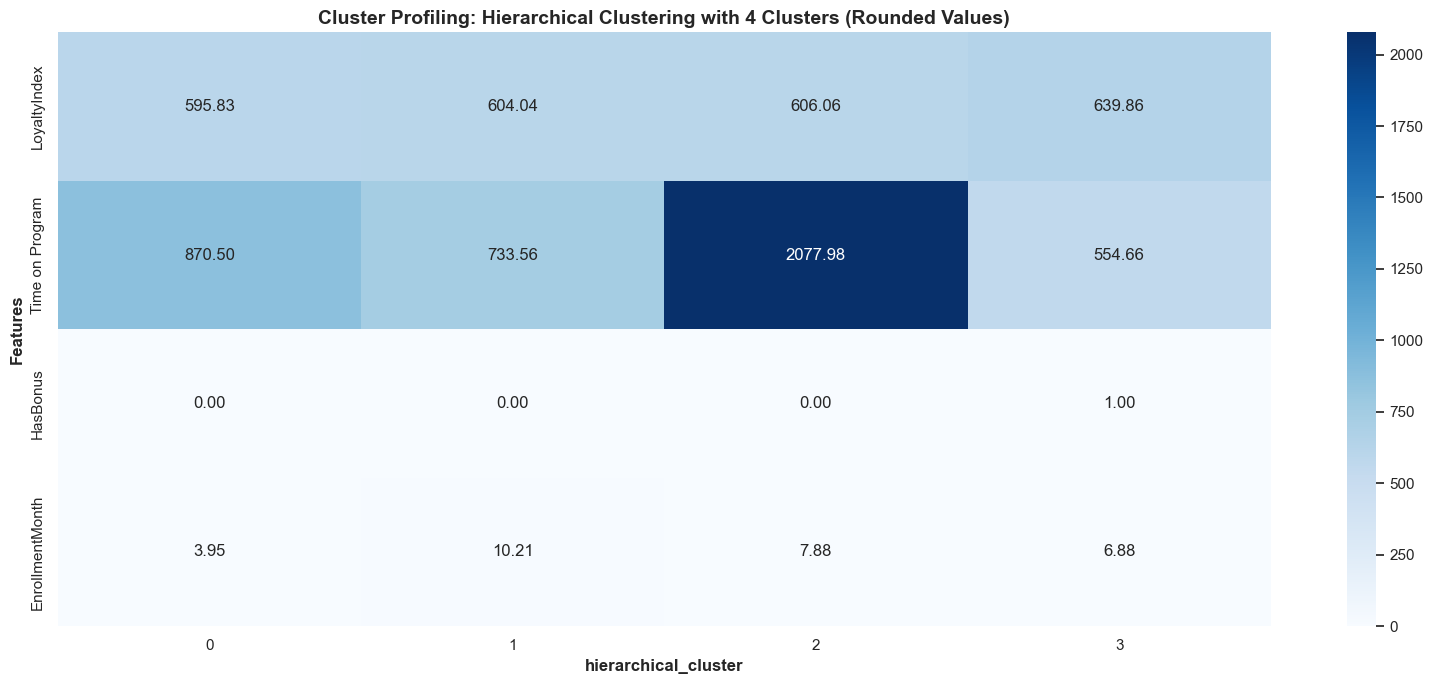

In [34]:
#Final clustering hierarchical with 4 clusters
hr = AgglomerativeClustering(n_clusters=4, linkage="ward", metric="euclidean")
hr_labels_4 = hr.fit_predict(loyalty_clustering)
print(f"  Cluster 0: {np.sum(hr_labels_4 == 0):,} customers")
print(f"  Cluster 1: {np.sum(hr_labels_4 == 1):,} customers")
print(f"  Cluster 2: {np.sum(hr_labels_4 == 2):,} customers")
print(f"  Cluster 3: {np.sum(hr_labels_4 == 3):,} customers")

# add hierarchical cluster labels to df
loyalty_clustering['hierarchical_cluster'] = hr_labels_4

features_to_cluster = loyalty_clustering.columns.drop('hierarchical_cluster')
# Inverse transform to get original scale
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(loyalty_clustering[features_to_cluster]),
    columns=features_to_cluster,
    index=loyalty_clustering.index
)

# Add cluster labels
df_original_scale['hierarchical_cluster'] = loyalty_clustering['hierarchical_cluster'].values
# Calculate mean per cluster (in original scale)
cluster_profile_original = df_original_scale.groupby('hierarchical_cluster')[features_to_cluster].mean()


plt.figure(figsize=(16, 7))
sns.heatmap(cluster_profile_original.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: Hierarchical Clustering with 4 Clusters (Rounded Values)", 
          fontweight='bold', fontsize=14)
plt.xlabel("hierarchical_cluster", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()


### Loyalty Perspective by Cluster

Based on the Hierarchical clustering with 4 clusters the purchasing behavior can be summarized as follows:

#### 1. **Newer Members but without bonus (Cluster 0)**
- **Pattern**: This represents newer members with moderate program engagement and no bonus.



#### 2. **Newer member but with a few bonus (Cluster 1)**
- **Pattern**: Members in this cluster enrolled later and spent less time in the program, showing moderate loyalty but minimal bonus benefits.

#### 3. **High loyal core members (Cluster 2)**
- **Pattern**: This is a cluster of long-term participants with very high program engagement but no bonus.


#### 3. **New High-Value Members with Bonus (Cluster 3)**
- **Pattern**: This cluster represents recent members with high loyalty and bonuses — possibly new high-value members incentivized by rewards.

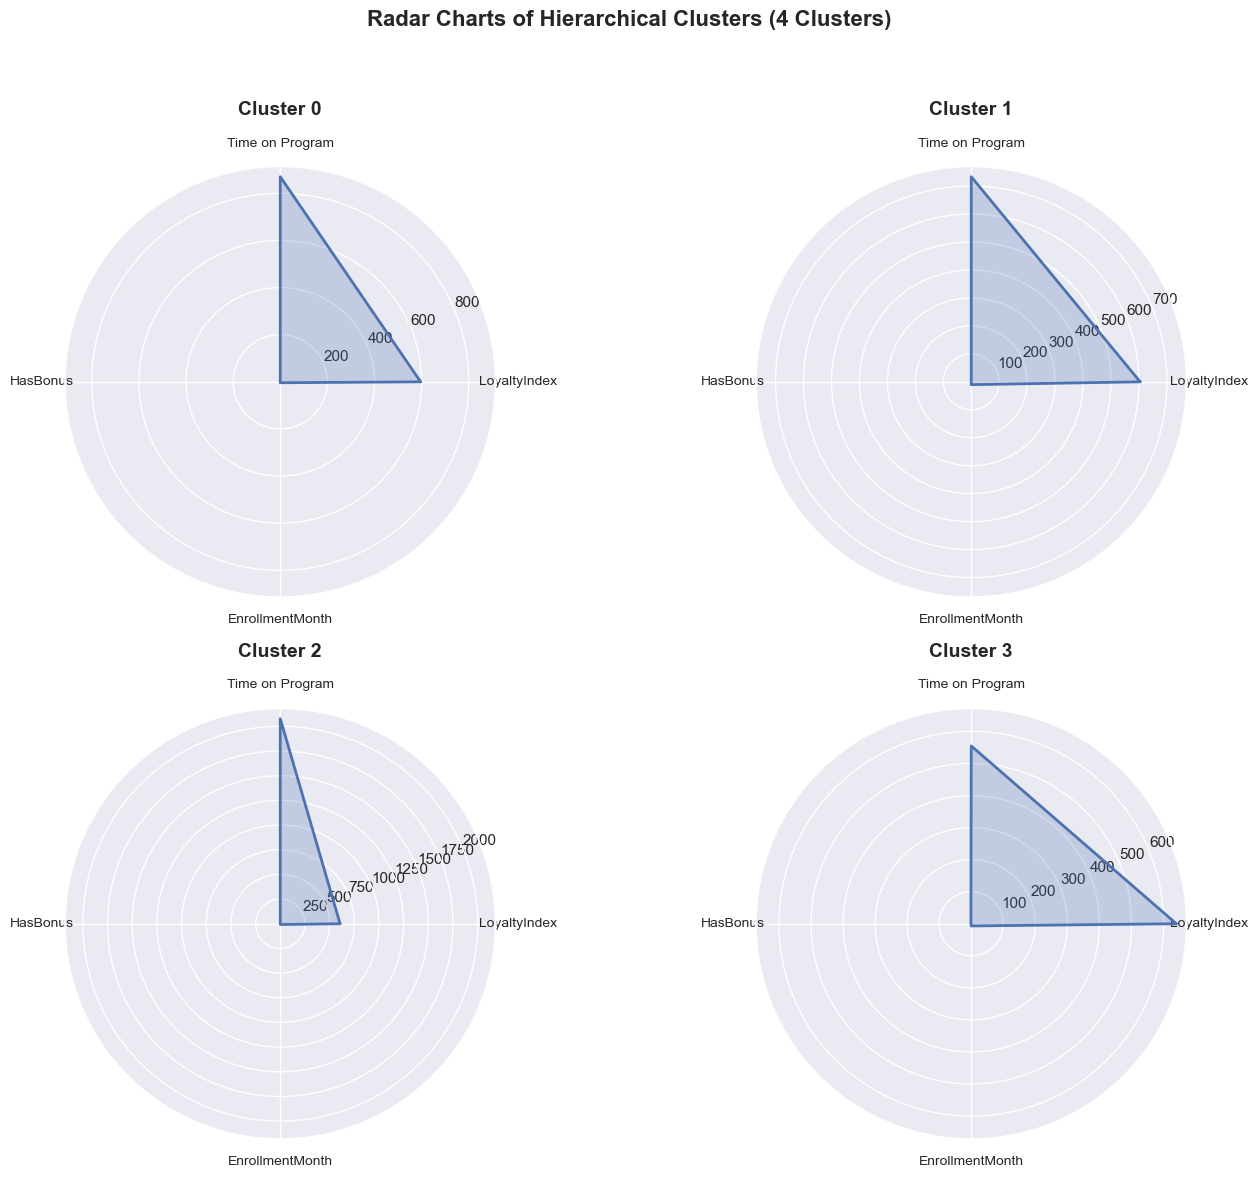

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Features
features = cluster_profile_original.columns
N = len(features)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Create 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12), subplot_kw=dict(polar=True))
axes = axes.flatten()

for i, cluster_id in enumerate(cluster_profile_original.index):
    values = cluster_profile_original.loc[cluster_id].values.flatten().tolist()
    values += values[:1]  # complete the loop
    ax = axes[i]
    ax.plot(angles, values, linewidth=2, color='b')
    ax.fill(angles, values, alpha=0.25, color='b')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=10)
    ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold', y=1.1)

plt.suptitle("Radar Charts of Hierarchical Clusters (4 Clusters)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [37]:
# Keep only the hierarchical cluster column
loyalty_cluster_csv = loyalty_clustering[['hierarchical_cluster']].copy()

# Save to CSV
loyalty_cluster_csv.to_csv('loyalty_cluster.csv', index=True)  # keeps the index (customer ID)
loyalty_cluster_csv.head()

,hierarchical_cluster
0,0
1,0
2,0
3,1
4,0
